# INTRODUCTION

## Libraries

In [1]:
import os
import datetime

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.compose import ColumnTransformer


import tensorflow as tf
from tensorflow.data import Dataset, AUTOTUNE

from keras import layers, models, Sequential, regularizers
from keras.layers import SimpleRNN, Dense, Dropout, Embedding, LSTM, GRU
from keras.optimizers.legacy import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.utils import timeseries_dataset_from_array
from keras.utils import plot_model
from keras.regularizers import L1, L2, L1L2

import keras_tuner as kt

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## Import data & column groups

In [2]:
DAILY_DATA_PATH = "data.v3/daily" 

df = pd.read_parquet(os.path.join(DAILY_DATA_PATH, "daily_flights_and_weather_merged.parquet"))

# Flights column groups
flights_terminal_cols = ['flights_arr_A', 'flights_arr_B', 'flights_arr_C', 'flights_arr_D', 'flights_arr_E',
                         'flights_dep_A', 'flights_dep_B', 'flights_dep_C', 'flights_dep_D', 'flights_dep_E']

flights_non_terminal_cols = ['flights_total', 'flights_cancel', 'flights_delay', 'flights_ontime',
                             'flights_arr_ontime', 'flights_arr_delay', 'flights_arr_cancel',
                             'flights_dep_ontime', 'flights_dep_delay', 'flights_dep_cancel']

flights_percentage_cols = ['flights_cancel_pct', 'flights_delay_pct', 'flights_ontime_pct',
                            'flights_arr_delay_pct', 'flights_arr_ontime_pct', 'flights_arr_cancel_pct',
                            'flights_dep_delay_pct', 'flights_dep_ontime_pct', 'flights_dep_cancel_pct']

# Date column groups
date_cols = ['date', 'covid', 'ordinal_date', 'year', 'month', 'day_of_month', 'day_of_week', 'season', 'holiday', 'halloween', 'xmas_eve', 'new_years_eve', 'jan_2', 'jan_3', 'day_before_easter', 'days_until_xmas', 'days_until_thanksgiving', 'days_until_july_4th', 'days_until_labor_day', 'days_until_memorial_day']

# Weather column groups
weather_cols = ['wx_temperature_max', 'wx_temperature_min', 'wx_apcp', 'wx_prate', 'wx_asnow', 'wx_frozr', 'wx_vis', 'wx_gust', 'wx_maxref', 'wx_cape', 'wx_lftx', 'wx_wind_speed', 'wx_wind_direction']

# Lag column groups
lag_cols =  ['flights_cancel_lag_1', 'flights_cancel_lag_2', 'flights_cancel_lag_3', 'flights_cancel_lag_4', 'flights_cancel_lag_5', 'flights_cancel_lag_6', 'flights_cancel_lag_7',
             'flights_delay_lag_1', 'flights_delay_lag_2', 'flights_delay_lag_3', 'flights_delay_lag_4', 'flights_delay_lag_5', 'flights_delay_lag_6', 'flights_delay_lag_7',
             'flights_ontime_lag_1', 'flights_ontime_lag_2', 'flights_ontime_lag_3', 'flights_ontime_lag_4', 'flights_ontime_lag_5', 'flights_ontime_lag_6', 'flights_ontime_lag_7',]

# Drop lag columns and date from data
df = df.drop(columns=lag_cols + ['date'])

print("Unique data types in df", df.dtypes.value_counts(), sep = '\n')

# Identify categorical and numeric columns in df
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = df.select_dtypes(include = ['float64', 'float32', 'int32', 'int64']).columns.tolist()
num_features = df.shape[1]

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numeric columns: {numeric_cols}")
print(f"\nAll columns accounted for: {len(categorical_cols) + len(numeric_cols) == num_features}")

Unique data types in df
float64    40
object     11
int64       7
float32     4
int32       2
Name: count, dtype: int64

Categorical columns: ['covid', 'month', 'day_of_week', 'season', 'holiday', 'halloween', 'xmas_eve', 'new_years_eve', 'jan_2', 'jan_3', 'day_before_easter']
Numeric columns: ['ordinal_date', 'year', 'day_of_month', 'days_until_xmas', 'days_until_thanksgiving', 'days_until_july_4th', 'days_until_labor_day', 'days_until_memorial_day', 'flights_cancel', 'flights_delay', 'flights_ontime', 'flights_arr', 'flights_dep', 'flights_arr_A', 'flights_arr_B', 'flights_arr_C', 'flights_arr_D', 'flights_arr_E', 'flights_dep_A', 'flights_dep_B', 'flights_dep_C', 'flights_dep_D', 'flights_dep_E', 'flights_arr_cancel', 'flights_arr_delay', 'flights_arr_ontime', 'flights_dep_cancel', 'flights_dep_delay', 'flights_dep_ontime', 'wx_temperature_max', 'wx_temperature_min', 'wx_apcp', 'wx_prate', 'wx_asnow', 'wx_frozr', 'wx_vis', 'wx_gust', 'wx_maxref', 'wx_cape', 'wx_lftx', 'wx_wind_speed

## Split data sequentially 70/20/10

In [3]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

# print data shapes
print(f"Train data shape: {train_df.shape}")
print(f"Validation data shape: {val_df.shape}")
print(f"Test data shape: {test_df.shape}")

Train data shape: (1179, 64)
Validation data shape: (337, 64)
Test data shape: (169, 64)


## Preprocess data for recurrent neural network (RNN)

In [4]:
# Fit transformers to the training data
scaler = StandardScaler()
scaler.fit(train_df[numeric_cols])

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # Some observed holidays may not be in the training data
ohe.fit(train_df[categorical_cols])
ohe_column_names = ohe.get_feature_names_out(input_features=categorical_cols)

# Define preprocessor
def preprocess(data):
    scaled_features = scaler.transform(data[numeric_cols])
    encoded_features = ohe.transform(data[categorical_cols])
    processed_data = pd.DataFrame(np.concatenate([scaled_features, encoded_features], axis=1),
                                  columns = numeric_cols + list(ohe_column_names))
    return processed_data

# Preprocess the data
train_df = preprocess(train_df)
val_df = preprocess(val_df)
test_df = preprocess(test_df)

print(f"\nNumber of columns before preprocessing: {num_features}")
print(f"Number of features after preprocessing: {train_df.shape[1]}")


Number of columns before preprocessing: 64
Number of features after preprocessing: 105


## WindowGenerator

In [5]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
               
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

## Instantiate WindowGenerators

In [6]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['flights_ontime'])

w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                        label_columns=['flights_ontime'])

## Add split_window method

In [7]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

# Add the method to the class
WindowGenerator.split_window = split_window

Demonstrate split_window on an example batch of 3 windows

In [8]:
# Stack three slices, the length of the total window. This creates an example batch of 3 windows, each of 7-timesteps and 105 features
example_batch = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_batch)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_batch.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 105)
Inputs shape: (3, 6, 105)
Labels shape: (3, 1, 1)


Create an "example" attribute for w2 and add the example batch inputs and labels

In [9]:
w2.example = example_inputs, example_labels

## Add plot method

In [10]:
def plot(self, model=None, plot_col='flights_ontime', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [days]')

# Add the method to the class
WindowGenerator.plot = plot

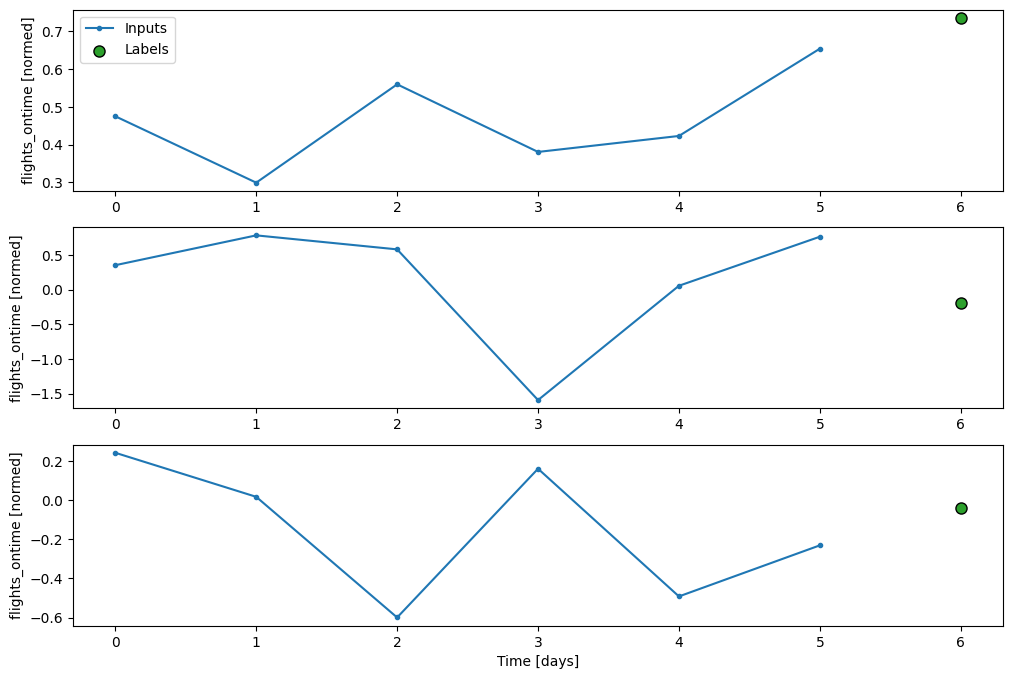

In [11]:
w2.plot()

## Add make_dataset

The make_dataset method creates TensorFlow timeseries datasets from the data objects held by WindowGenerator. The split_window function is mapped over the windows of the TensorFlow datasets, creating inputs and labels for each window. 

In [12]:
def make_dataset(self,data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)
    
    ds = ds.map(self.split_window)
    
    return ds

# Add the method to the class
WindowGenerator.make_dataset = make_dataset

Add properties for accessing the train, validation, and test datasets as TensorFlow timeseries datasets created by make_dataset. The `@property` decorator is used to define getter methods for properties of a class, allowing access to the result of a method as an attribute of the class. 

In [13]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

# Add the properties to the class (redundant becuase the train, val, test, and example properties are already defined in the class)
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

The `element_spec` attribute 

Inspect an element of a tf.data.Dataset of w2 using the element_spec attribute

In [14]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 105), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

 Iterating over a tf timeseries dataset produced and held within a WindowGenerator instance, e.g. `w2.train` produces batches of data, where each batch has an input tensor and a labels tensor.

In [15]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 105)
Labels shape (batch, time, features): (32, 1, 1)


## single_step_window

In [16]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['flights_ontime'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['flights_ontime']

Like for w2.train, iterating over single_step_window.train produces batches of two Tensors, inputs and labels. w2 used 6 steps in the input and single_step_window uses 1.

In [17]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 105)
Labels shape (batch, time, features): (32, 1, 1)


## Baseline
The baseline class will use a current label to predict a label one step into the future. We hope to beat this model with a LSTM recurrent network.

In [18]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

The baseline model of using the previous day's ontime flights to predict the next day's ontime flights produced baseline MSE and MAE values of 2.51 and 1.36 respectively. Again, we'll try to beat this with a LSTM recurrent network.

In [20]:
baseline = Baseline(label_index=column_indices['flights_ontime'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)


11/11 [==============================] - 0s 916us/step - loss: 2.5069 - mean_absolute_error: 1.3683


In [ ]:
wide_window = WindowGenerator(
    input_width=28, label_width=28, shift=1,
    label_columns=['flights_ontime'])

wide_window

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

In [ ]:
wide_window.plot(baseline)